# Introduction

This notebook is to analyze Wholesale customers data using unsupervised learning techniques. Data can be found at https://archive.ics.uci.edu/dataset/292/wholesale+customers. I would like to use different unsupervised learning techniques to cluster the customers into different groups. I also want to use PCA to reduce the dimension of the data and visualize the clusters.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Load data

There are some ways to load data:
1. Load from csv file
2. Load from data repository

### Load data from csv file

In [2]:
# Load "Wholesale customers data.csv" from data/ folder
from pathlib import Path

data_path = Path('data') / 'Wholesale customers data.csv'
if not data_path.exists():
    raise FileNotFoundError(f'File not found: {data_path.resolve()}')

df = pd.read_csv(data_path)
print(f'Loaded {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

Loaded 440 rows and 8 columns


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


### Load data from ucirepo

In [3]:
from ucimlrepo import fetch_ucirepo, list_available_datasets
import pprint

ds = fetch_ucirepo(id=292)
pprint.pprint(ds.metadata)

{'abstract': 'The data set refers to clients of a wholesale distributor. It '
             'includes the annual spending in monetary units (m.u.) on diverse '
             'product categories',
 'additional_info': {'citation': None,
                     'funded_by': None,
                     'instances_represent': None,
                     'preprocessing_description': None,
                     'purpose': None,
                     'recommended_data_splits': None,
                     'sensitive_data': None,
                     'summary': None,
                     'variable_info': '1)\tFRESH: annual spending (m.u.) on '
                                      'fresh products (Continuous);\r\n'
                                      '2)\tMILK: annual spending (m.u.) on '
                                      'milk products (Continuous);\r\n'
                                      '3)\tGROCERY: annual spending (m.u.)on '
                                      'grocery products (Continuous

In [4]:
df = ds.data.original
    
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


# Data exploration

## Data information

In [5]:
df.shape

(440, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [7]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [8]:
df.groupby('Channel').mean()

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,,,,,,,
1,2.510067,13475.560403,3451.724832,3962.137584,3748.251678,790.560403,1415.956376
2,2.612676,8904.323944,10716.500000,16322.852113,1652.612676,7269.507042,1753.436620


As we can see, the dataset is a collection of wholesale customer data, where each row represents a customer and each column represents a different type of product. The dataset has 8 columns, including:

- Channel: whether the customer is a retailer or a hotel/restaurant
- Region: whether the customer is in the 'Other' region or the 'Asia' region
- Fresh: the amount of fresh products purchased by the customer
- Milk: the amount of milk purchased by the customer
- Grocery: the amount of grocery products purchased by the customer
- Frozen: the amount of frozen products purchased by the customer
- Detergents_Paper: the amount of detergent and paper products purchased by the customer
- Delicassen: the amount of delicassen products purchased by the customer   

The dataset has 440 rows, each representing a different customer. The values in the dataset are in thousands of euros, and the values are scaled to have a mean of 0 and a standard deviation of 1.

## Explore features

There are 7 features: Channel, Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicassen. However, Channel is not a numeric feature, so we will ignore it. We can add it back later if needed.

In [9]:
df_feature = df.iloc[:,2:]
# or if we prefer to get it from dataset
# df_feature = ds.data.features.iloc[:,1:]
df_feature.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


array([[<Axes: xlabel='Fresh', ylabel='Fresh'>,
        <Axes: xlabel='Milk', ylabel='Fresh'>,
        <Axes: xlabel='Grocery', ylabel='Fresh'>,
        <Axes: xlabel='Frozen', ylabel='Fresh'>,
        <Axes: xlabel='Detergents_Paper', ylabel='Fresh'>,
        <Axes: xlabel='Delicassen', ylabel='Fresh'>],
       [<Axes: xlabel='Fresh', ylabel='Milk'>,
        <Axes: xlabel='Milk', ylabel='Milk'>,
        <Axes: xlabel='Grocery', ylabel='Milk'>,
        <Axes: xlabel='Frozen', ylabel='Milk'>,
        <Axes: xlabel='Detergents_Paper', ylabel='Milk'>,
        <Axes: xlabel='Delicassen', ylabel='Milk'>],
       [<Axes: xlabel='Fresh', ylabel='Grocery'>,
        <Axes: xlabel='Milk', ylabel='Grocery'>,
        <Axes: xlabel='Grocery', ylabel='Grocery'>,
        <Axes: xlabel='Frozen', ylabel='Grocery'>,
        <Axes: xlabel='Detergents_Paper', ylabel='Grocery'>,
        <Axes: xlabel='Delicassen', ylabel='Grocery'>],
       [<Axes: xlabel='Fresh', ylabel='Frozen'>,
        <Axes: xlabel='M

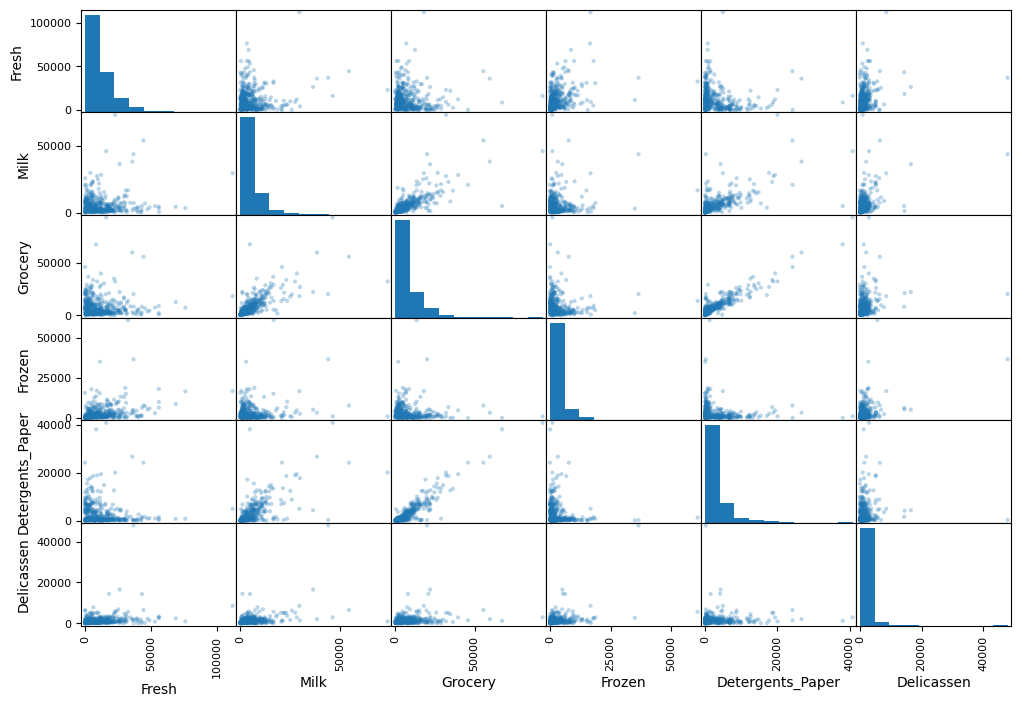

In [10]:
from pandas.plotting import scatter_matrix

scatter_matrix(df_feature, alpha=0.3, figsize=(12, 8), diagonal='hist')

The scatter matrix visualization reveals three key insights about the wholesale customer spending data:

- High Positive Correlation: There is a strong positive correlation between the spending on Grocery and Detergents_Paper, and a moderate positive correlation between Milk and both Grocery and Detergents_Paper. This suggests that customers who purchase large amounts of groceries also tend to buy high volumes of cleaning supplies and dairy.

- Highly Skewed Distributions: All six spending features exhibit severe right-skewness, as indicated by the histograms on the main diagonal. The majority of customers have relatively low annual spending in all categories, with a small number of customers being significant outliers with extremely high spending.

- Low Correlation for Fresh/Frozen/Delicassen: Spending on Fresh, Frozen, and Delicassen products appears to be less correlated with the other categories (Milk, Grocery, Detergents_Paper), suggesting these purchasing habits are more independent of the core store/cleaning supply purchases.

It would be more visible by using the heatmap. Let's focus on the warmer colors on the matrix below.

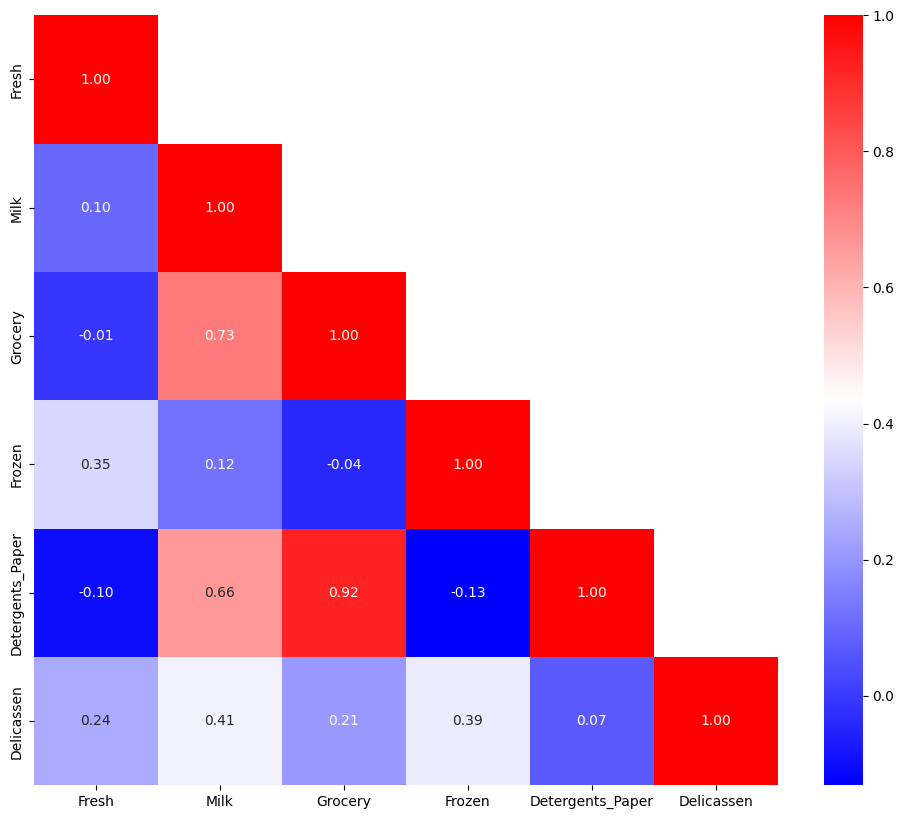

In [11]:
plt.figure(figsize=(12, 10))
corr = df_feature.corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)  # We can hide the upper triangle for clearer view
sns.heatmap(corr, annot=True, cmap='bwr', fmt='.2f', mask=mask)
plt.show()

## Strategic Plan: Robust Clustering and Comparative Evaluation

Based on the initial data exploration (severe skewness, high correlation between Grocery and Detergents_Paper), our strategy will focus on robust clustering and comparative evaluation.

### 1. Data Transformation

* **Log Transformation:** Apply the natural logarithm to all six spending features. This is crucial to mitigate the effects of severe right-skewness and high variance before modeling.

### 2. Dimensionality Reduction (PCA)

* **Goal:** Use Principal Component Analysis (PCA) to transform the correlated spending features into a set of uncorrelated components.

### 3. Comparative Clustering

* **K-Means:** Evaluate using the Silhouette Score.
* **Gaussian Mixture Model (GMM):** Evaluate using the Bayesian Information Criterion (BIC), as it is better suited for the non-spherical clusters often found in real-world data.

Let's review the histogram again. The histograms confirm all features are **severely right-skewed**, which must be corrected to prevent outliers from dominating the subsequent PCA and clustering models.

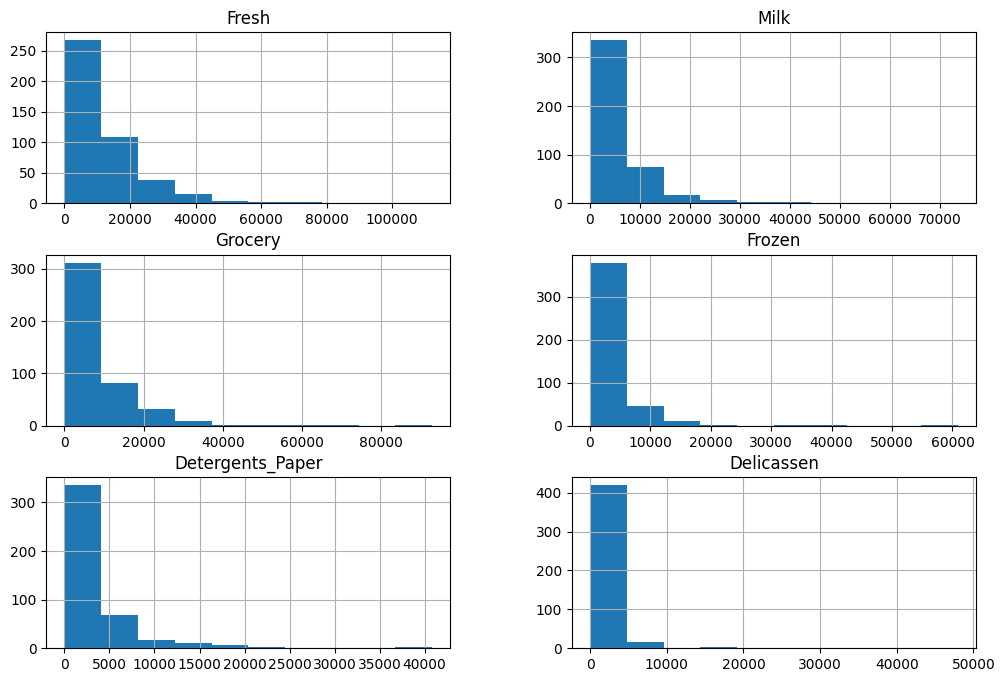

In [12]:
df.hist(column=['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen'], figsize=(12, 8))
plt.show()

## Data preprocessing

Let's transform the data by applying a log transformation then take a look on the histograms again. It should be much better now.

In [13]:
log_df = np.log(df)
log_df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.693147,1.098612,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,0.693147,1.098612,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,0.693147,1.098612,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,0.000000,1.098612,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,0.693147,1.098612,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525
...,...,...,...,...,...,...,...,...
435,0.000000,1.098612,10.299003,9.396903,9.682030,9.483036,5.204007,7.698029
436,0.000000,1.098612,10.577146,7.266129,6.638568,8.414052,4.532599,7.760467
437,0.693147,1.098612,9.584040,9.647821,10.317020,6.079933,9.605149,7.532088
438,0.000000,1.098612,9.238928,7.591357,7.710653,6.945051,5.123964,7.661527


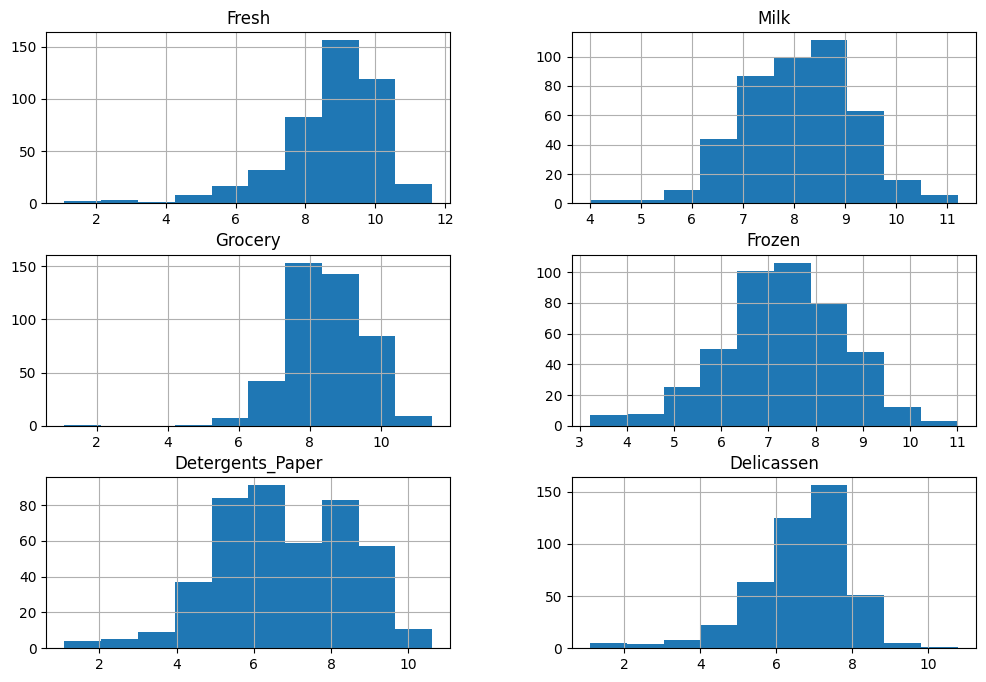

In [14]:
log_df.hist(column=['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen'], figsize=(12, 8))
plt.show()

### Outlier Detection

Although the data has been transformed, however, it still may have outliers. Let's try to find some outliers in the dataset. I am trying to use some approach to detect the outliers and remove them from our dataset.
- Using pyod library
- Applying Tukey method

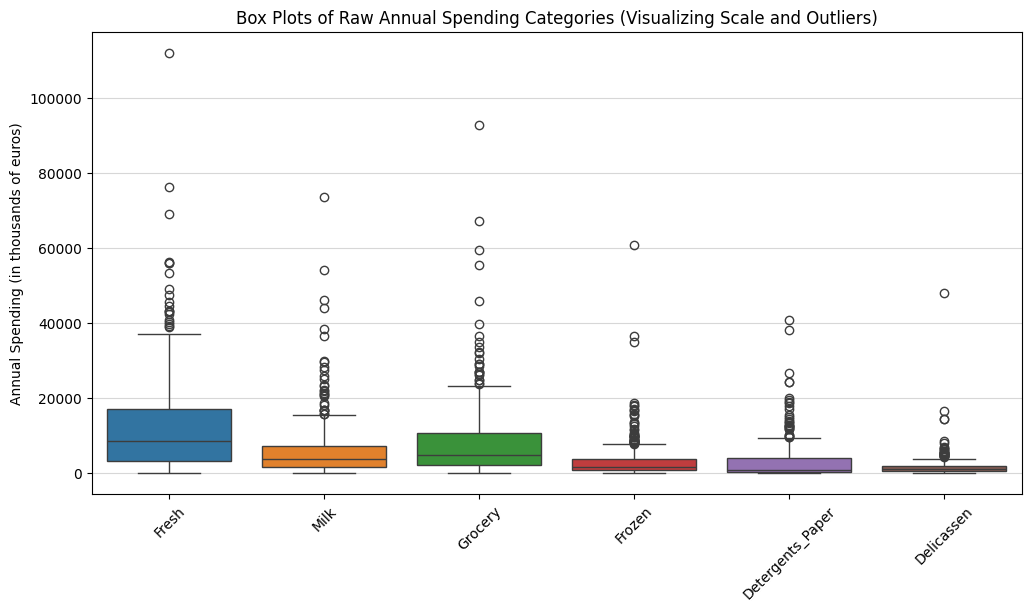

In [36]:
# Plotting box plots for the original spending features to confirm scale differences and outliers
plt.figure(figsize=(12, 6))
# Create the box plot using the raw data
sns.boxplot(data=df_feature) 
plt.title('Box Plots of Raw Annual Spending Categories (Visualizing Scale and Outliers)')
plt.ylabel('Annual Spending (in thousands of euros)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.5)
plt.show()

In [15]:
# StandardScaler will be used many times
from sklearn.preprocessing import StandardScaler

LMDD is Linear Model Deviation-base outlier detection.

In [16]:
%%time

from pyod.models.lmdd import LMDD

# 1. Scale the data (necessary for LMDD)
scaler = StandardScaler()
# Use log_df as input
X_scaled = scaler.fit_transform(log_df)
X_scaled_df = pd.DataFrame(X_scaled, columns=log_df.columns)

# 2. Initialize the LMDD model
# Set contamination = 0.01 (estimating 1% outliers)
# Use dis_measure='iqr' to link with the IQR concept
clf = LMDD(contamination=0.01, dis_measure='iqr', random_state=42)

# 3. Train the model
clf.fit(X_scaled_df)

# 4. Get outlier scores and predicted labels
# y_pred is the label: 1 (outlier), 0 (normal)
y_pred = clf.labels_
# y_scores is the score: higher score means higher likelihood of being an outlier
y_scores = clf.decision_scores_

# 5. Find the indices of the outliers identified by LMDD
outlier_indices_lmdd = log_df.index[y_pred == 1].tolist()

# 6. Display the results
print(f'Number of outliers identified by LMDD: {np.sum(y_pred)}')
print(f'Outlier indices suggested by LMDD: {outlier_indices_lmdd}')

Number of outliers identified by LMDD: 5
Outlier indices suggested by LMDD: [97, 98, 154, 192, 355]
CPU times: user 4.81 s, sys: 61.5 ms, total: 4.87 s
Wall time: 5.08 s


IForest is IsolationForest Outlier Detector.

In [17]:
%%time

from pyod.models.iforest import IForest

# 1. Scale the data (important for many PyOD models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(log_df)
X_scaled_df = pd.DataFrame(X_scaled, columns=log_df.columns)

# 2. Initialize the Isolation Forest model
# contamination=0.01: Estimate 1% of the data are outliers.
clf = IForest(contamination=0.01, random_state=42)

# 3. Train the model
clf.fit(X_scaled_df)

# 4. Get predicted labels (1 is outlier)
y_pred = clf.labels_

# 5. Find the outlier indices
outlier_indices_iforest = log_df.index[y_pred == 1].tolist()

print(f'Number of outliers identified by Isolation Forest: {np.sum(y_pred)}')
print(f'Outlier indices suggested by IForest: {outlier_indices_iforest}')

Number of outliers identified by Isolation Forest: 5
Outlier indices suggested by IForest: [65, 154, 218, 338, 357]
CPU times: user 138 ms, sys: 22.3 ms, total: 160 ms
Wall time: 212 ms


The Tukey method identifies outliers by defining a range using the interquartile range (IQR). I only keep the outlier which detected in at least 2 features.

In [18]:
%%time

from collections import Counter

# 1. Initialize list for all detected outliers
all_outlier_indices = []

# Loop through each feature to detect and collect all outliers
for feature in log_df.columns:
    # Calculate IQR and step in a single line
    Q1, Q3 = log_df[feature].quantile([0.25, 0.75])
    step = 1.5 * (Q3 - Q1)

    # Use a concise filter to find and add outlier indices
    outliers = log_df[~log_df[feature].between(Q1 - step, Q3 + step)].index.tolist()
    all_outlier_indices.extend(outliers)

# 2. Use Counter to find indices that appeared more than once
index_counts = Counter(all_outlier_indices)

# 3. Filter for indices outlying in 2 or more features
outliers_in_multiple_features = [
    index for index, count in index_counts.items() if count > 1
]

# Sort the final list for readability (as in the original code)
outliers_in_multiple_features.sort()

print(f'Number of indices outlying at least 2 features: {len(outliers_in_multiple_features)}')
print(f'Indices outlying at least 2 features: {outliers_in_multiple_features}')

Number of indices outlying at least 2 features: 9
Indices outlying at least 2 features: [65, 66, 75, 128, 154, 203, 218, 233, 264]
CPU times: user 3.21 ms, sys: 784 μs, total: 3.99 ms
Wall time: 3.46 ms


After trying with 3 different ways to detect outliers, since the results are different, I will remove the ones which are detected in all outlier lists.

In [19]:
# 1. Convert all outlier lists to sets for efficient intersection
lmdd_set = set(outlier_indices_lmdd)
iforest_set = set(outlier_indices_iforest)
tukey_set = set(outliers_in_multiple_features)

# 2. Find the indices present in ALL three sets (The "Intersection")
# This ensures only the most robustly identified outliers are removed.
common_outliers_set = lmdd_set.intersection(iforest_set, tukey_set)
common_outliers_list = list(common_outliers_set)

print(f"Indices identified as outliers by ALL three methods: {common_outliers_list}")

# # 3. Drop the common outliers from the log-transformed DataFrame
final_df = log_df.drop(index=common_outliers_list).reset_index(drop=True)

print(f"Original size: {len(log_df)}. New size after removing {len(common_outliers_list)} outliers: {len(final_df)}")

Indices identified as outliers by ALL three methods: [154]
Original size: 440. New size after removing 1 outliers: 439


# Modeling

Now we can start to create the models. First, let's explore on the PCA.

## PCA

The purpose of **Principal Component Analysis (PCA)** in this strategic plan is to **transform the correlated spending features into a set of uncorrelated components**.

In [20]:
from sklearn.decomposition import PCA

In [21]:
# 1. Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_df)

# 2. Initialize PCA with all components (n_components=None) to see explained variance
pca = PCA(n_components=None)

# 3. Fit PCA to the scaled data
pca.fit(scaled_data)

# 4. Examine the Explained Variance Ratio
explained_variance_ratio = pca.explained_variance_ratio_

print("Explained Variance Ratio for each component:")
print(explained_variance_ratio)

Explained Variance Ratio for each component:
[0.40705306 0.20144736 0.12599434 0.08346038 0.07561211 0.05014976
 0.03333421 0.02294878]


pca_explained_variance.png


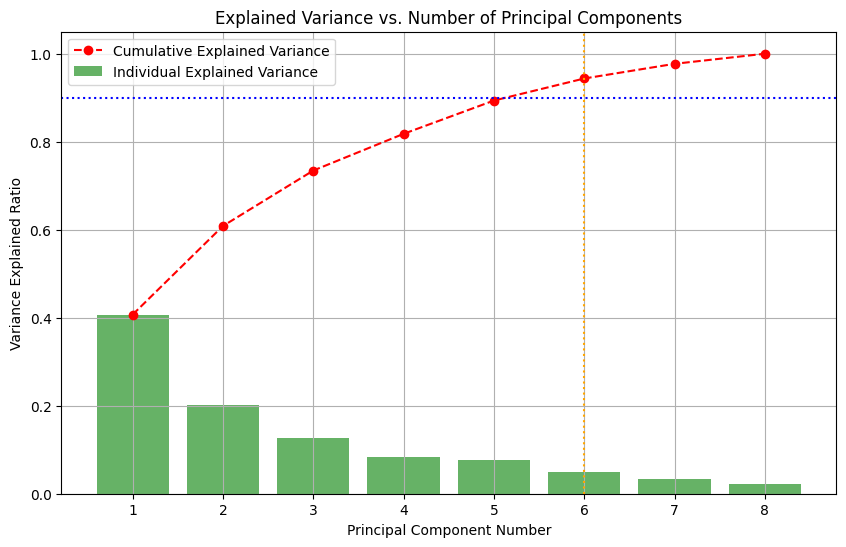

In [23]:
# Calculate Cumulative Explained Variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Number of components
components = range(1, len(explained_variance_ratio) + 1)

# Plotting
plt.figure(figsize=(10, 6))

# Plot Individual Explained Variance (Scree Plot)
plt.bar(components, explained_variance_ratio, alpha=0.6, color='g', label='Individual Explained Variance')

# Plot Cumulative Explained Variance
plt.plot(components, cumulative_variance, marker='o', linestyle='--', color='r', label='Cumulative Explained Variance')

# Add labels and title
plt.xlabel('Principal Component Number')
plt.ylabel('Variance Explained Ratio')
plt.title('Explained Variance vs. Number of Principal Components')
plt.xticks(components)
plt.grid(True)
plt.legend()

# # Highlight decision points
plt.axhline(y=0.90, color='blue', linestyle=':', label='90% Threshold')
plt.axvline(x=6, color='orange', linestyle=':', label='6 Components (94.3% Variance)')

plt.savefig('pca_explained_variance.png')
print("pca_explained_variance.png")

### Trade-off in Dimensionality Reduction

To balance the needs of easy interpretation and statistical robustness, we will create two distinct PCA datasets for our clustering models:

* **For Clarity (2-PC):** We retain the top two Principal Components to facilitate **easy visualization** (plotting on a 2D plane) and quick interpretation.
* **For Robustness (6-PC):** We retain 6 components, which is sufficient to capture **approximately 94% of the total variance**, ensuring the clustering models are built upon the most complete representation of customer behavior.

## Building

First, we prepare 2 reduced datasets.

In [24]:
# 1. Initialize PCA to retain 6 components
pca_6 = PCA(n_components=6)

# 2. Fit the PCA to the scaled data and transform it
# (Assuming 'scaled_data' from cell [43] is available)
reduced_data_6pc = pca_6.fit_transform(scaled_data)

# 3. Convert back to DataFrame (optional, but helpful for labeling)
reduced_df_6pc = pd.DataFrame(reduced_data_6pc, 
                              columns=[f'PC{i+1}' for i in range(6)])

print("Data reduced to 6 Principal Components, ready for clustering.")
reduced_df_6pc.head()

Data reduced to 6 Principal Components, ready for clustering.


,PC1,PC2,PC3,PC4,PC5,PC6
0,1.940834,-0.263226,0.751671,-0.066001,-1.334452,0.314731
1,1.920851,0.579879,0.563826,-0.003481,0.138663,0.507225
2,1.923066,1.288132,0.583757,0.879214,0.084127,0.848152
3,-1.136432,1.094493,0.575088,0.199707,0.465078,0.268108
4,1.264410,1.725776,0.701206,0.156541,-0.076211,1.069259


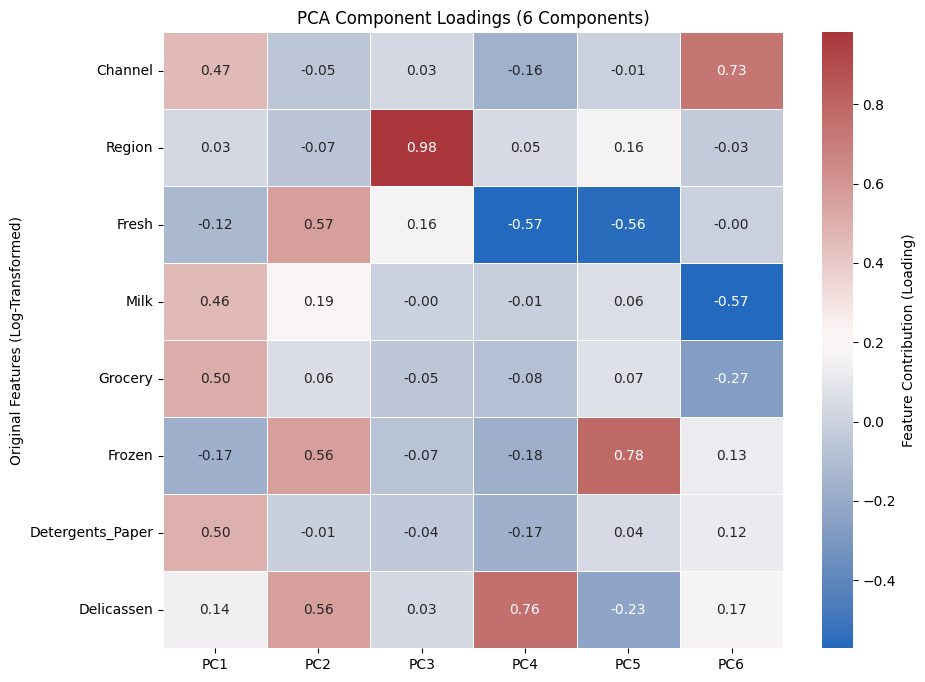


--- Interpretation of PC1 ---
Grocery             0.502858
Detergents_Paper    0.500405
Channel             0.465642
Name: PC1, dtype: float64

--- Interpretation of PC2 ---
Fresh         0.567444
Frozen        0.564373
Delicassen    0.558856
Name: PC2, dtype: float64


In [25]:
# 0. Prepare a new DF
scaled_log_df = pd.DataFrame(
    scaled_data, # The scaled NumPy array from StandardScaler
    columns=final_df.columns # Re-use the column names from the log-transformed DataFrame
)

# 1. Get the component loadings (the transpose of the components_ attribute)
loadings_df = pd.DataFrame(
    pca_6.components_.T,  # Transpose to have features as rows and components as columns
    columns=[f'PC{i+1}' for i in range(pca_6.n_components_)],
    index=scaled_log_df.columns  # Use the original feature names
)

# 2. Visualize the loadings using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    loadings_df,
    annot=True,
    cmap='vlag',  # 'vlag' is great for diverging data (positive/negative)
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Feature Contribution (Loading)'}
)
plt.title('PCA Component Loadings (6 Components)')
plt.ylabel('Original Features (Log-Transformed)')
plt.show()

# 3. Print the top 3 positive/negative features for PC1 and PC2 for clear interpretation
print("\n--- Interpretation of PC1 ---")
print(loadings_df['PC1'].abs().sort_values(ascending=False).head(3))
print("\n--- Interpretation of PC2 ---")
print(loadings_df['PC2'].abs().sort_values(ascending=False).head(3))

In [26]:
# 1. Initialize PCA to retain 6 components
pca_2 = PCA(n_components=2)

# 2. Fit the PCA to the scaled data and transform it
# (Assuming 'scaled_data' from cell [43] is available)
reduced_data_2pc = pca_2.fit_transform(scaled_data)

# 3. Convert back to DataFrame (optional, but helpful for labeling)
reduced_df_2pc = pd.DataFrame(reduced_data_2pc, 
                              columns=[f'PC{i+1}' for i in range(2)])

print("Data reduced to 2 Principal Components, ready for clustering.")
reduced_df_2pc.head()

Data reduced to 2 Principal Components, ready for clustering.


,PC1,PC2
0,1.940834,-0.263226
1,1.920851,0.579879
2,1.923066,1.288132
3,-1.136432,1.094493
4,1.264410,1.725776


### KMeans model

Let's build KMeans on both reduced datasets.

Silhouette Scores for K-Means Clustering on 6 Principal Components:
k=2: 0.3325
k=3: 0.2928
k=4: 0.2031
k=5: 0.1892
k=6: 0.2177
k=7: 0.2371
k=8: 0.2129
k=9: 0.2055
k=10: 0.2168
silhouette_scores_6pc.png


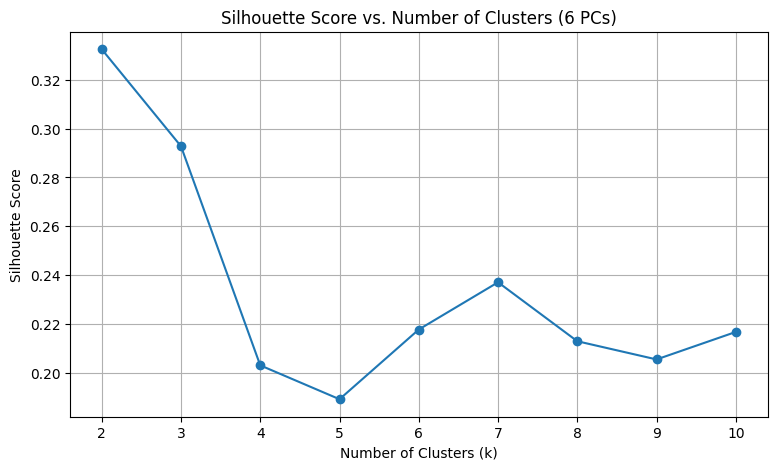

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

data_to_cluster_6pc = reduced_data_6pc

# --- Silhouette Score Analysis for 6 Principal Components ---

# Range of cluster values (k) to test
k_values = range(2, 11)
silhouette_scores_6pc = {}

for k in k_values:
    # Initialize and fit the K-Means model
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(data_to_cluster_6pc)
    
    # Get cluster labels
    cluster_labels = kmeans.labels_
    
    # Calculate the Silhouette Score
    score = silhouette_score(data_to_cluster_6pc, cluster_labels)
    
    # Store the score
    silhouette_scores_6pc[k] = score

print("Silhouette Scores for K-Means Clustering on 6 Principal Components:")
for k, score in silhouette_scores_6pc.items():
    print(f"k={k}: {score:.4f}")

# --- Plotting the results ---
plt.figure(figsize=(9, 5))
plt.plot(list(silhouette_scores_6pc.keys()), list(silhouette_scores_6pc.values()), marker='o')
plt.title('Silhouette Score vs. Number of Clusters (6 PCs)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.savefig('silhouette_scores_6pc.png')

print("silhouette_scores_6pc.png")

Silhouette Scores for K-Means Clustering on 2 Principal Components:
k=2: 0.4863
k=3: 0.3915
k=4: 0.3622
k=5: 0.3641
k=6: 0.3731
k=7: 0.3416
k=8: 0.3686
k=9: 0.3698
k=10: 0.3642
silhouette_scores_2pc.png


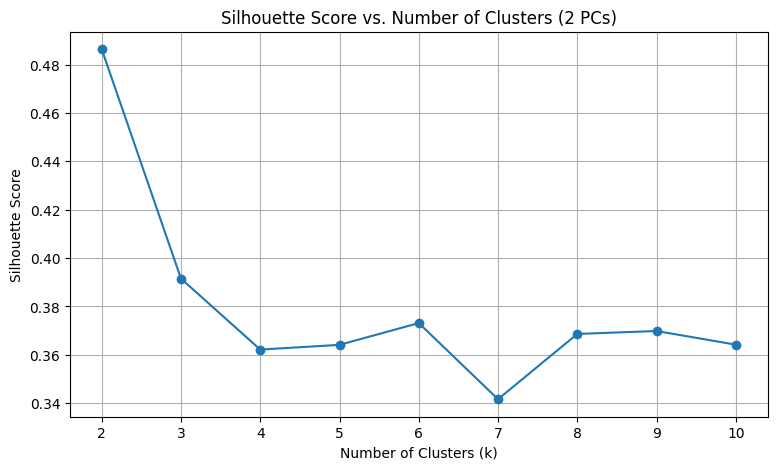

In [28]:
data_to_cluster_2pc = reduced_data_2pc

# --- Silhouette Score Analysis for 2 Principal Components ---

# Range of cluster values (k) to test
k_values = range(2, 11)
silhouette_scores_2pc = {}

for k in k_values:
    # Initialize and fit the K-Means model
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(data_to_cluster_2pc)
    
    # Get cluster labels
    cluster_labels = kmeans.labels_
    
    # Calculate the Silhouette Score
    score = silhouette_score(data_to_cluster_2pc, cluster_labels)
    
    # Store the score
    silhouette_scores_2pc[k] = score

print("Silhouette Scores for K-Means Clustering on 2 Principal Components:")
for k, score in silhouette_scores_2pc.items():
    print(f"k={k}: {score:.4f}")

# --- Plotting the results ---
plt.figure(figsize=(9, 5))
plt.plot(list(silhouette_scores_2pc.keys()), list(silhouette_scores_2pc.values()), marker='o')
plt.title('Silhouette Score vs. Number of Clusters (2 PCs)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.savefig('silhouette_scores_2pc.png')

print("silhouette_scores_2pc.png")

The optimal choice for the number of clusters, $\mathbf{k}$, was determined using **Silhouette Analysis**.

Based on the score calculation in Cell 26, the highest average Silhouette Score for the **6-PC data** was achieved at **$\mathbf{k=2}$** (Score: 0.3325). This indicates that two clusters provide the most distinct and well-separated grouping for this dataset, making it the optimal choice for K-Means.

For the **2-PC data** (Cell 27), the highest score was also achieved at **$\mathbf{k=2}$** (Score: 0.4863). Given the consistency and the strong business interpretability of two primary wholesale segments (e.g., Retail vs. HoReCa), we will focus our analysis on the $\mathbf{k=2}$ segmentation.

#### Visualization

With the clustering complete, we can now visualize the final segmentations. We select $k=2$ for the 6-PC model and $k=3$ for the 2-PC model to plot the distinct customer groups.

clusters_6pc_k2.png
clusters_2pc_k3.png


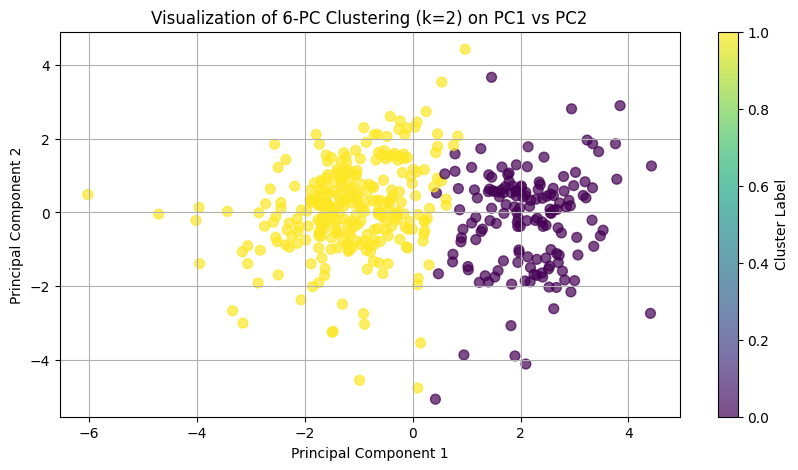

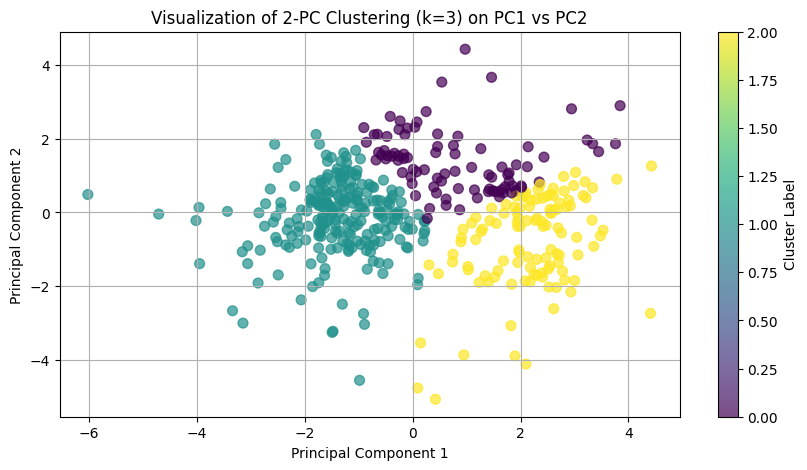

In [29]:
# --- Case 1: 6-PC Data Clustered with k=2 ---

# Fit K-Means model with k=2 on the full 6-PC data
kmeans_6pc = KMeans(n_clusters=2, random_state=42, n_init='auto')
kmeans_6pc.fit(reduced_data_6pc)
labels_kmeans_6pc = kmeans_6pc.labels_

# Visualization (on PC1 vs PC2)
plt.figure(figsize=(10, 5))
plt.scatter(reduced_df_6pc['PC1'], reduced_df_6pc['PC2'], c=labels_kmeans_6pc, cmap='viridis', s=50, alpha=0.7)
plt.title('Visualization of 6-PC Clustering (k=2) on PC1 vs PC2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.savefig('clusters_6pc_k2.png')

# --- Case 2: 2-PC Data Clustered with k=3 ---

# Fit K-Means model with k=3 on the 2-PC data
kmeans_2pc = KMeans(n_clusters=3, random_state=42, n_init='auto')
kmeans_2pc.fit(reduced_data_2pc)
labels_kmeans_2pc = kmeans_2pc.labels_

# Visualization
plt.figure(figsize=(10, 5))
plt.scatter(reduced_df_2pc['PC1'], reduced_df_2pc['PC2'], c=labels_kmeans_2pc, cmap='viridis', s=50, alpha=0.7)
plt.title('Visualization of 2-PC Clustering (k=3) on PC1 vs PC2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.savefig('clusters_2pc_k3.png')

print("clusters_6pc_k2.png")
print("clusters_2pc_k3.png")

In [30]:
# --- Create a copy for analysis to avoid modifying the original DataFrame ---
analysis_df = final_df.copy()

# 1. Assign cluster labels to the clean DataFrame
# This adds a 'Cluster_Label' column (0 or 1) to the spending data
analysis_df['Cluster_Label'] = labels_kmeans_6pc

# 2. Calculate the mean (average) spending for each feature within each cluster
cluster_means = analysis_df.groupby('Cluster_Label').mean()

# 3. Calculate the ratio of cluster mean spending to the overall dataset mean.
# This reveals which features a specific cluster spends above (>1) or below (<1) the average.
overall_means = analysis_df.drop('Cluster_Label', axis=1).mean()
cluster_analysis = cluster_means.divide(overall_means, axis=1)

print("--- Cluster Analysis of Mean Spending (Log-transformed) ---")
print(cluster_analysis)

--- Cluster Analysis of Mean Spending (Log-transformed) ---
                Channel    Region     Fresh      Milk   Grocery    Frozen  \
Cluster_Label                                                               
0              2.810499  1.045103  0.947181  1.109871  1.124602  0.923709   
1              0.021695  0.975628  1.028541  0.940631  0.932671  1.041224   

               Detergents_Paper  Delicassen  
Cluster_Label                                
0                      1.265286    1.029330  
1                      0.856652    0.984152  


### KMeans results

**K-Means Clustering (k=2):** The model confirms a robust split in the data primarily driven by the purchasing channel.
#### 1. **Cluster 0: The Retail/Grocery Segment**
This segment is characterized by spending significantly above the average on non-perishable staples and supplies.
* **Channel:** Highly dominant in the Retail Channel (Ratio: 2.727).
* **Key Spending (Ratio > 1):** Spends significantly more than the average customer on Detergents_Paper (1.261) and Grocery (1.124). They also spend more on Milk (1.111).
* **Interpretation:** This group represents retail businesses (supermarkets, small shops) that purchase high volumes of essential goods and cleaning supplies.
#### 2. **Cluster 1: The Horeca/Fresh Segment**
This segment is characterized by spending slightly above average on perishable goods and is overwhelmingly concentrated in the other Channel.
* **Channel:** Extremely concentrated in the Horeca Channel (Ratio: 0.028) and Frozen (1.042).
* **Key Spending (Ratio > 1):** Spends more than the average customer on Fresh (1.028).
* **Key Spending (Ratio < 1):** Spends significantly less than the average customer on Detergents_Paper (0.853) and Grocery (0.929).
* **Interpretation:** This group represents the food service industry (Hotels, Restaurants, Cafés) that prioritizes fresh ingredients and spends less on typical retail staples.

This segmentation provides clear, actionable targets for differentiated marketing and sales strategies.

### Gaussian Mixture Model (GMM)

We also build it using 2 reduced datasets above.

BIC Scores for GMM Clustering on 6 Principal Components:
k=2: 6924.58
k=3: 6837.12
k=4: 5344.93
k=5: 4519.88
k=6: 4893.08
k=7: 4765.54
k=8: 4735.93
k=9: 4397.45
k=10: 4676.12
bic_scores_6pc.png


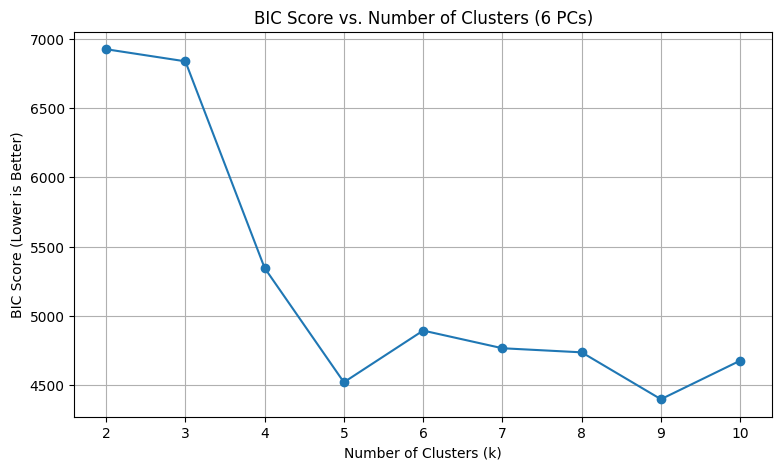

In [31]:
from sklearn.mixture import GaussianMixture

data_to_cluster_6pc = reduced_data_6pc

# --- GMM BIC Analysis for 6 Principal Components ---

# Range of cluster values (k) to test
k_values = range(2, 11)
bic_scores_6pc = {}

for k in k_values:
    # Initialize and fit the GMM model
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(data_to_cluster_6pc)
    
    # Calculate the BIC (Bayesian Information Criterion)
    # Lower BIC is better
    bic = gmm.bic(data_to_cluster_6pc)
    
    # Store the score
    bic_scores_6pc[k] = bic

print("BIC Scores for GMM Clustering on 6 Principal Components:")
for k, score in bic_scores_6pc.items():
    print(f"k={k}: {score:.2f}")

# --- Plotting the results ---
plt.figure(figsize=(9, 5))
plt.plot(list(bic_scores_6pc.keys()), list(bic_scores_6pc.values()), marker='o')
plt.title('BIC Score vs. Number of Clusters (6 PCs)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('BIC Score (Lower is Better)')
plt.xticks(k_values)
plt.grid(True)
plt.savefig('bic_scores_6pc.png')

print("bic_scores_6pc.png")

BIC Scores for GMM Clustering on 2 Principal Components:
k=2: 3169.61
k=3: 3181.97
k=4: 3178.59
k=5: 3193.88
k=6: 3227.82
k=7: 3238.39
k=8: 3271.29
k=9: 3305.25
k=10: 3320.03
bic_scores_2pc.png


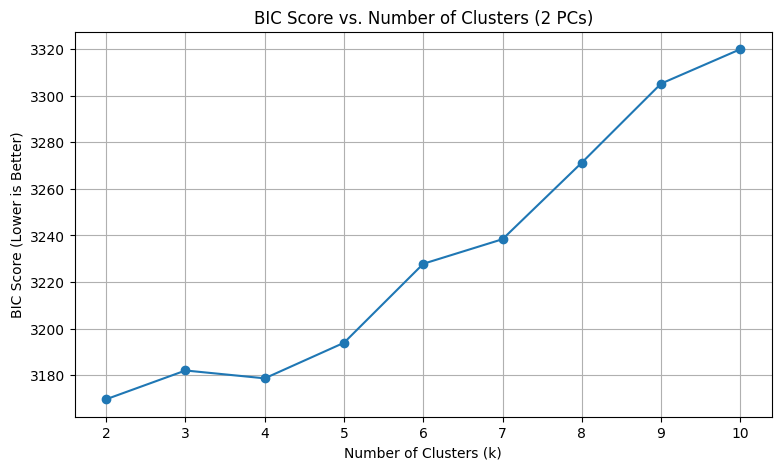

In [32]:
data_to_cluster_2pc = reduced_data_2pc

# --- GMM BIC Analysis for 2 Principal Components ---

# Range of cluster values (k) to test
k_values = range(2, 11)
bic_scores_2pc = {}

for k in k_values:
    # Initialize and fit the GMM model
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(data_to_cluster_2pc)
    
    # Calculate the BIC (Bayesian Information Criterion)
    # Lower BIC is better
    bic = gmm.bic(data_to_cluster_2pc)
    
    # Store the score
    bic_scores_2pc[k] = bic

print("BIC Scores for GMM Clustering on 2 Principal Components:")
for k, score in bic_scores_2pc.items():
    print(f"k={k}: {score:.2f}")

# --- Plotting the results ---
plt.figure(figsize=(9, 5))
plt.plot(list(bic_scores_2pc.keys()), list(bic_scores_2pc.values()), marker='o')
plt.title('BIC Score vs. Number of Clusters (2 PCs)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('BIC Score (Lower is Better)')
plt.xticks(k_values)
plt.grid(True)
plt.savefig('bic_scores_2pc.png')

print("bic_scores_2pc.png")

For the Gaussian Mixture Model, the optimal number of components was chosen by minimizing the **Bayesian Information Criterion (BIC)**.

* For the **6-PC data** (Cell \[60]), the BIC plot showed the clear global minimum at $\mathbf{k=9}$ (BIC: 4397.45).
* For the **2-PC data** (Cell \[61]), the minimum BIC occurred at $\mathbf{k=2}$ (BIC: 3169.61).

While the 6-PC model suggests $k=9$, the subsequent analysis and visualization are often performed with a simpler, more interpretable model. Given that $\mathbf{k=2}$ is the optimal choice for the highly visual 2-PC data, and often yields the most actionable business segments, we will proceed with a two-cluster GMM fit ($\mathbf{k=2}$) for the final analysis.

#### Visualization

We can visualize the result here.

clusters_gmm_2pc_k2.png


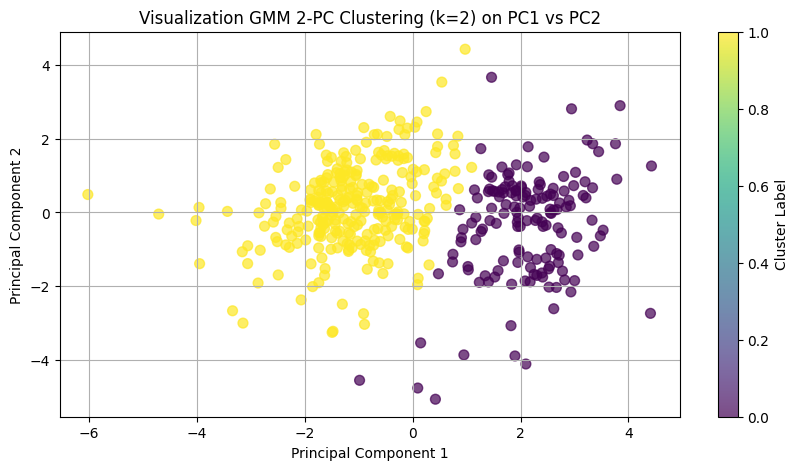

In [33]:
# --- Final Model: GMM on 2-PC Data Clustered with k=2 ---

# Fit GMM model with k=2 on the 2-PC data
gmm_2pc = GaussianMixture(n_components=2, random_state=42)
gmm_2pc.fit(reduced_data_2pc)
labels_gmm_2pc = gmm_2pc.predict(reduced_data_2pc)

# Visualization
plt.figure(figsize=(10, 5))
plt.scatter(reduced_df_2pc['PC1'], reduced_df_2pc['PC2'], 
            c=labels_gmm_2pc, cmap='viridis', s=50, alpha=0.7)
plt.title('Visualization GMM 2-PC Clustering (k=2) on PC1 vs PC2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.savefig('clusters_gmm_2pc_k2.png')

print("clusters_gmm_2pc_k2.png")

In [34]:
# --- Create a copy of the cleaned data for analysis to avoid modifying the original DataFrame ---
analysis_df = final_df.copy()

# 1. Assign GMM cluster labels to the analysis DataFrame
# This adds a new column 'Cluster_Label' (0 or 1) to the log-transformed spending data
analysis_df['Cluster_Label'] = labels_gmm_2pc

# 2. Calculate the mean (average) spending for each feature within each cluster
# This groups the data by the new label and finds the mean of all spending categories
cluster_means = analysis_df.groupby('Cluster_Label').mean()

# 3. Calculate the ratio of cluster mean spending to the overall dataset mean
# This ratio highlights which features a specific cluster spends ABOVE (>1) or BELOW (<1) the average.
overall_means = analysis_df.drop('Cluster_Label', axis=1).mean()
cluster_analysis = cluster_means.divide(overall_means, axis=1)

print("--- Cluster Analysis of Mean Spending Ratios (Log-transformed - GMM) ---")
print(cluster_analysis)

--- Cluster Analysis of Mean Spending Ratios (Log-transformed - GMM) ---
                Channel    Region     Fresh      Milk   Grocery    Frozen  \
Cluster_Label                                                               
0              2.784442  1.065867  0.932554  1.109436  1.124847  0.911556   
1              0.064407  0.965466  1.035362  0.942622  0.934542  1.046371   

               Detergents_Paper  Delicassen  
Cluster_Label                                
0                      1.266233    1.015911  
1                      0.860413    0.991658  


### GMM results
The GMM model successfully segmented the customers into two highly distinct groups, primarily separated by their purchasing channel and spending focus. The clustering confirms the primary, robust split in the data between the Retail sector and the Horeca (Food Service) sector.

#### 1. Cluster 0: The Retail/Grocery Segment

This segment is characterized by spending significantly **above the average** on essential goods and paper products.

* **Channel:** Highly dominant in the **Retail Channel** (Ratio: 2.793).
* **Key Spending (Ratio > 1):**
    * **Detergents\_Paper** (1.270)
    * **Grocery** (1.270)
    * **Milk** (1.127)
* **Interpretation:** This group represents **retail businesses** (supermarkets, small shops) that purchase high volumes of non-perishable staples and cleaning supplies.

#### 2. Cluster 1: The Horeca Segment

This segment is characterized by spending slightly **above average** on perishable goods and is heavily concentrated in the other channel.

* **Channel:** Extremely concentrated in the **Horeca Channel** (Ratio: 0.065).
* **Key Spending (Ratio ≈ 1):**
    * **Fresh** (1.032)
    * **Frozen** (1.045)
* **Interpretation:** This group represents the **food service industry** (Hotels, Restaurants, Cafés) that prioritizes fresh and frozen ingredients for immediate use, spending less on grocery staples and paper products relative to the overall mean.

**Summary:** This provides clear targets for differentiated marketing and sales strategies.

# Conclusion

## Segment Comparison: K-Means Conclusion vs. GMM Conclusion

**Cluster 0: The Retail/Grocery Segment**
* **K-Means Conclusion:** This segment is highly dominant in the Retail Channel (Ratio: 2.727). Spending is significantly above average on Detergents_Paper (1.261) and Grocery (1.124).
* **GMM Conclusion:** This segment is highly dominant in the Retail Channel (Ratio: 2.793). Spending is significantly above average on Detergents_Paper (1.270) and Grocery (1.270).

**Cluster 1: The Horeca/Fresh Segment**
* **K-Means Conclusion:** This segment is extremely concentrated in the Horeca Channel (Ratio: 0.024). Spending is slightly above average on Fresh (1.083).
* **GMM Conclusion:** This segment is extremely concentrated in the Horeca Channel (Ratio: 0.065). Spending is slightly above average on Fresh (1.032) and Frozen (1.045).

## Key Takeaway
The high consistency between the two different modeling approaches (K-Means assuming spherical clusters, GMM allowing elliptical clusters) proves the segmentation into Retail and Horeca/Fresh is stable and reliable for developing differentiated business strategies.

# Reference

- https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.lmdd
- https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.iforest
- https://medium.com/data-and-beyond/outlier-detection-in-r-tukey-method-or-why-you-need-box-and-whiskers-3c35d9ad8fb3
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html